# <center> Convolutional Neural Network

### Convolutional Layers: [128,128,128] ; Dense Layers [128,128,128] 
### CNN regularized with l1 regularization in dense layers

CNN is trained on raw data

## <font color = 'blue'> Get the data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time
from functools import partial

%store -r
%store

Stored variables and their in-db values:
X_test              -> defaultdict(<class 'list'>, {0: array([[[-0.000654
X_train             -> array([[[-0.00107939, -0.00131855, -0.00122601, ..
snrs                -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_test              -> defaultdict(<class 'list'>, {0: array([5, 5, 5, ..
y_train             -> array([4, 6, 7, ..., 2, 7, 4])


In [2]:
print("Training data: ", X_train.shape, "and labels: ", y_train.shape)
print()
print("Test data:")
print("Total", len(X_test), X_test[18].shape, "arrays for SNR values:")
print(sorted(X_test.keys()))

Training data:  (80000, 2, 128) and labels:  (80000,)

Test data:
Total 20 (4000, 2, 128) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## <font color = 'blue'> Standardize the features

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
_X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
_X_train = sc.fit_transform(_X_train)

X_train = np.reshape(_X_train, X_train.shape)
print("Training set", X_train.shape)

_X_test = defaultdict(list)
for snr in snrs:
    _X_test[snr] = np.reshape(X_test[snr], [X_test[snr].shape[0], X_test[snr].shape[1]*X_test[snr].shape[2]])
    _X_test[snr] = sc.transform(_X_test[snr])
    X_test[snr] = np.reshape(_X_test[snr], X_test[snr].shape)
    
print("Test set corresponding to one snr value", X_test[18].shape)

Training set (80000, 2, 128)
Test set corresponding to one snr value (4000, 2, 128)


## <font color = 'blue'> Design and train the CNN

In [6]:
height = 2
width = 128
channels = 1
n_features = height * width

feature_map1 = 128
ksize_conv1 = 2
stride_conv1 = 1

feature_map2 = 128
ksize_conv2 = ksize_conv1
stride_conv2 = stride_conv1

feature_map3 = 128
ksize_conv3 = ksize_conv1
stride_conv3 = stride_conv1

pool_layer_maps = 128

n_fully_conn1 = 128
n_fully_conn2 = 128
n_fully_conn3 = 128

n_classes = 8
  
X = tf.placeholder(tf.float32, shape=[None, height, width])
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
labels = tf.placeholder(tf.int32, shape=[None])

weight_init = tf.contrib.layers.xavier_initializer()
activation_func = tf.nn.relu

# ------------------ Convolutional and pooling layers ----------------------------

def convolutional_layer(X, filter_, ksize, kernel_init, strides, padding):
    convolutional_layer = tf.layers.conv2d(X, filters = filter_, kernel_initializer = kernel_init,
                                           kernel_size = ksize, strides = strides,
                                          padding = padding, activation = activation_func)
    return convolutional_layer

def pool_layer(convlayer, ksize, strides, padding, pool_maps):
    pool = tf.nn.max_pool(convlayer, ksize, strides, padding)
    dim1, dim2 = int(pool.get_shape()[1]), int(pool.get_shape()[2])
    pool_flat = tf.reshape(pool, shape = [-1, pool_maps * dim1 * dim2])
    return pool_flat

conv_layer1 = convolutional_layer(X_reshaped, feature_map1, ksize_conv1, weight_init, stride_conv1, padding = "SAME")

conv_layer2 = convolutional_layer(conv_layer1, feature_map2, ksize_conv2, weight_init, stride_conv2, padding = "SAME")

conv_layer3 = convolutional_layer(conv_layer2, feature_map3, ksize_conv3, weight_init, stride_conv3, padding = "SAME")

pool_layer_flat = pool_layer(conv_layer3, [1,2,2,1], [1,2,2,1], "VALID", pool_layer_maps)

# ----------------- Fully connected layers -------------------

scale_val = 0.001
new_dense_layer = partial(tf.layers.dense, kernel_initializer = weight_init,
                          kernel_regularizer = tf.contrib.layers.l1_regularizer(scale_val), 
                          activation = activation_func)

dense_layer1 = new_dense_layer(pool_layer_flat, n_fully_conn1)

dense_layer2 = new_dense_layer(dense_layer1, n_fully_conn2)

dense_layer3 = new_dense_layer(dense_layer2, n_fully_conn3)

# ----------------- Output softmax layer ---------------------------

logits = tf.layers.dense(dense_layer3, n_classes)
softmax_activations = tf.nn.softmax(logits)

# ----------------- Specify performance measure -------------------------------

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels)

loss = tf.reduce_mean(cross_entropy)
regularization_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
total_loss = tf.add_n([loss] + regularization_loss)

optimizer = tf.train.AdamOptimizer()
train_operation = optimizer.minimize(total_loss)

correct_predictions = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# ---------------- Execution phase -------------------------------------------
    
n_epochs = 10
batch_size = 1024
n_train = X_train.shape[0]
n_iter = n_train//batch_size

acc_test = defaultdict(list)

path = "./CNN_regtech_l1.1"  
saver = tf.train.Saver()

start = time()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size)    
            X_batch, y_batch = X_train[rand_indices], y_train[rand_indices]
            sess.run(train_operation, feed_dict={X: X_batch, labels: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, labels: y_batch})
        print("Epoch {} training accuracy : {}".format(epoch, acc_train))
        save_path = saver.save(sess, path)
        saver.restore(sess, path)
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_test[snr], labels: y_test[snr]})

print("Training took %f minutes"%(float(time() - start)/60.0))

Epoch 0 training accuracy : 0.20703125
INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Epoch 1 training accuracy : 0.2353515625
INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Epoch 2 training accuracy : 0.232421875
INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Epoch 3 training accuracy : 0.2626953125
INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Epoch 4 training accuracy : 0.251953125
INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Epoch 5 training accuracy : 0.29296875
INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Epoch 6 training accuracy : 0.30859375
INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Epoch 7 training accuracy : 0.283203125
INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Epoch 8 training accuracy : 0.31640625
INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Epoch 9 training accuracy : 0.322265625
INFO:tensorflow:Restoring parameters from ./CNN_regte

## <font color = 'blue'> Test the classifier

In [7]:
for snr in snrs:
    print("CNN's test accuracy on {}dB SNR samples = {}".format(snr,acc_test[snr]))  

CNN's test accuracy on -20dB SNR samples = 0.11599999666213989
CNN's test accuracy on -18dB SNR samples = 0.1197500005364418
CNN's test accuracy on -16dB SNR samples = 0.12925000488758087
CNN's test accuracy on -14dB SNR samples = 0.13574999570846558
CNN's test accuracy on -12dB SNR samples = 0.16574999690055847
CNN's test accuracy on -10dB SNR samples = 0.2160000056028366
CNN's test accuracy on -8dB SNR samples = 0.2757500112056732
CNN's test accuracy on -6dB SNR samples = 0.3160000145435333
CNN's test accuracy on -4dB SNR samples = 0.2952499985694885
CNN's test accuracy on -2dB SNR samples = 0.3232499957084656
CNN's test accuracy on 0dB SNR samples = 0.359250009059906
CNN's test accuracy on 2dB SNR samples = 0.41624999046325684
CNN's test accuracy on 4dB SNR samples = 0.4325000047683716
CNN's test accuracy on 6dB SNR samples = 0.43650001287460327
CNN's test accuracy on 8dB SNR samples = 0.4165000021457672
CNN's test accuracy on 10dB SNR samples = 0.42925000190734863
CNN's test accura

## <font color = 'blue'> Visualize classifier's performance on test set

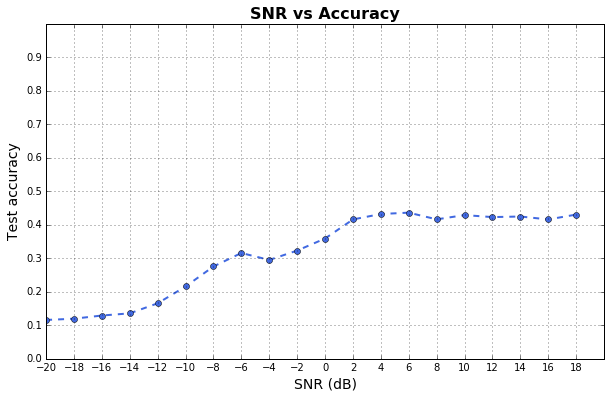

In [8]:
plt.style.use('classic')
%matplotlib inline

acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test_values = new_acc 

fig1 = plt.figure(figsize=(10, 6), dpi=100)
x = snrs
y = list(acc_test_values)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

INFO:tensorflow:Restoring parameters from ./CNN_regtech_l1.1
Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK    NaN   NaN    NaN   NaN   NaN    NaN    NaN   NaN
BPSK   0.01  0.66   0.00  0.03  0.26   0.01   0.01  0.03
CPFSK  0.17  0.00   0.46  0.12  0.00   0.10   0.12  0.03
GFSK   0.18  0.00   0.04  0.36  0.00   0.19   0.16  0.08
PAM4   0.00  0.41   0.00  0.01  0.57   0.01   0.00  0.00
QAM16  0.00  0.00   0.00  0.40  0.00   0.00   0.20  0.40
QAM64  0.22  0.00   0.08  0.18  0.00   0.22   0.22  0.08
QPSK   0.05  0.00   0.00  0.10  0.00   0.14   0.11  0.60


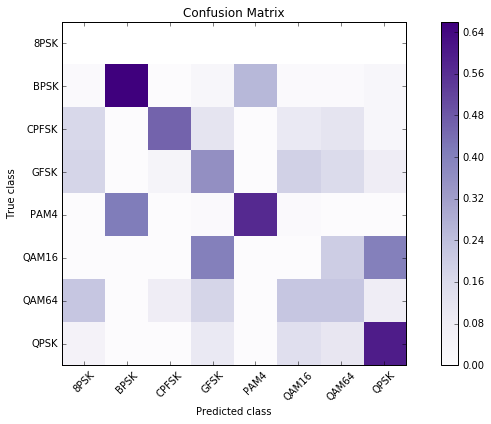

In [9]:
# Confusion Matrix

with tf.Session() as sess:
    saver.restore(sess, path)
    Z = logits.eval(feed_dict = {X : X_test[18]})
    predicted_18dB = np.argmax(Z, axis = 1)
    
from sklearn.metrics import confusion_matrix
%matplotlib inline

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
conf_matrix = confusion_matrix(predicted_18dB, y_test[18])  

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

import pandas as pd

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()